*Read section 4.7.6 of the book before using these notes.*

*Note that in this course, lecture notes are not sufficient, you must read the book for better understanding. Lecture notes are just implementing the concepts of the book on a dataset, but not explaining the concepts elaborately.*

In [14]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.35)

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict, KFold, RepeatedKFold

## KNN for regression

In [2]:
#Using the same datasets as used for linear regression in STAT303-2, 
#so that we can compare the non-linear models with linear regression
trainf = pd.read_csv('./Datasets/Car_features_train.csv')
trainp = pd.read_csv('./Datasets/Car_prices_train.csv')
testf = pd.read_csv('./Datasets/Car_features_test.csv')
testp = pd.read_csv('./Datasets/Car_prices_test.csv')
train = pd.merge(trainf,trainp)
test = pd.merge(testf,testp)
train.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,18473,bmw,6 Series,2020,Semi-Auto,11,Diesel,145,53.3282,3.0,37980
1,15064,bmw,6 Series,2019,Semi-Auto,10813,Diesel,145,53.0430,3.0,33980
2,18268,bmw,6 Series,2020,Semi-Auto,6,Diesel,145,53.4379,3.0,36850
3,18480,bmw,6 Series,2017,Semi-Auto,18895,Diesel,145,51.5140,3.0,25998
4,18492,bmw,6 Series,2015,Automatic,62953,Diesel,160,51.4903,3.0,18990


In [3]:
predictors = ['mpg', 'engineSize', 'year', 'mileage']

X_train = train[predictors]
y_train = train['price']

X_test = test[predictors]
y_test = test['price']

Let us scale data as we are using KNN.

### Scaling data

In [4]:
# Scale
sc = StandardScaler()

sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

Let fit the model and compute the RMSE on test data. If the number of neighbors is not specified, the default value is taken.

### Fitting and validating model

In [5]:
knn_model = KNeighborsRegressor() 

knn_model.fit(X_train_scaled, (y_train))

y_pred = knn_model.predict(X_test_scaled)
y_pred_train = knn_model.predict(X_train_scaled)

mean_squared_error(y_test, (y_pred), squared=False)

6329.691192885354

In [6]:
knn_model2 = KNeighborsRegressor(n_neighbors = 5, weights='distance') # Default weights is uniform

knn_model2.fit(X_train_scaled, y_train)

y_pred = knn_model2.predict(X_test_scaled)

mean_squared_error(y_test, y_pred, squared=False)

6063.327598353961

The model seems to fit better than all the linear models in STAT303-2. 

### Hyperparameter tuning

We will use cross-validation to find the optimal value of the hyperparameter `n_neighbors`. 

In [7]:
Ks = np.arange(1,601)

cv_scores = []

for K in Ks:
    model = KNeighborsRegressor(n_neighbors = K, weights='distance')
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring = 'neg_root_mean_squared_error')
    cv_scores.append(score)

In [8]:
np.array(cv_scores).shape
# Each row is a K

(600, 5)

In [9]:
cv_scores_array = np.array(cv_scores)

avg_cv_scores = -cv_scores_array.mean(axis=1)

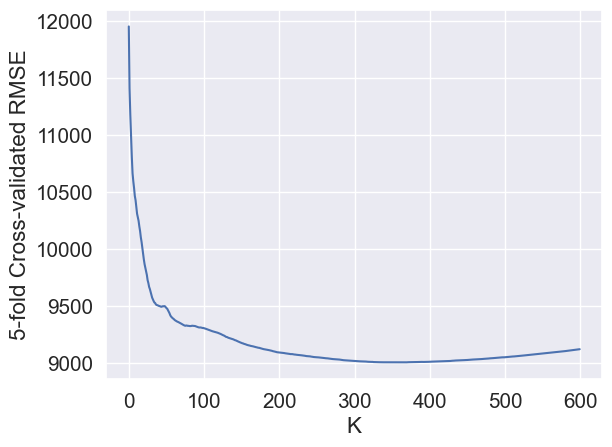

In [10]:
sns.lineplot(x = range(600), y = avg_cv_scores);
plt.xlabel('K')
plt.ylabel('5-fold Cross-validated RMSE');

In [11]:
avg_cv_scores.min() # Best CV score
 
Ks[avg_cv_scores.argmin()] # Best hyperparam value

366

The optimal hyperparameter value is 366. Does it seem to be too high?

In [12]:
best_model = KNeighborsRegressor(n_neighbors = Ks[avg_cv_scores.argmin()], weights='distance')

best_model.fit(X_train_scaled, y_train)

y_pred = best_model.predict(X_test_scaled)

mean_squared_error(y_test, y_pred, squared=False)

7724.452068618346

**The test error with the optimal hyperparameter value based on cross-validation is much higher than that based on the default value of the hyperparameter**. Why is that?

Sometimes this may happen by chance due to the specific observations in the $k$ folds. One option is to shuffle the dataset before splitting into folds.

In [16]:
kcv = KFold(n_splits = 5, shuffle = True, random_state = 1)

Now, let us again try to find the opimal $K$ for KNN, using the new folds, based on shuffled data.

In [17]:
Ks = np.arange(1,601)

cv_scores = []

for K in Ks:
    model = KNeighborsRegressor(n_neighbors = K, weights='distance')
    score = cross_val_score(model, X_train_scaled, y_train, cv = kcv, scoring = 'neg_root_mean_squared_error')
    cv_scores.append(score)

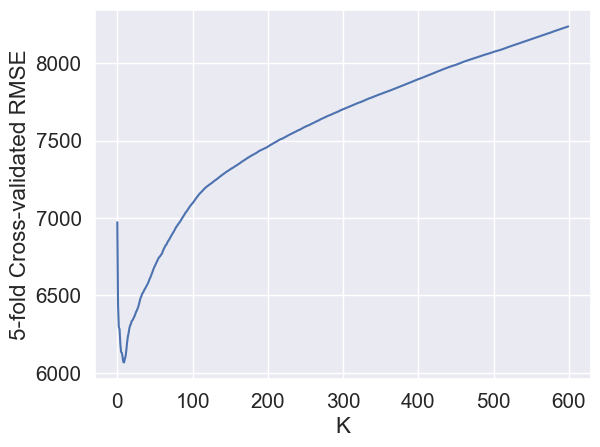

In [18]:
cv_scores_array = np.array(cv_scores)
avg_cv_scores = -cv_scores_array.mean(axis=1)
sns.lineplot(x = range(600), y = avg_cv_scores);
plt.xlabel('K')
plt.ylabel('5-fold Cross-validated RMSE');

The optimal K is:

In [19]:
Ks[avg_cv_scores.argmin()]

10

RMSE on test data with this optimal value of $K$ is:

In [20]:
knn_model2 = KNeighborsRegressor(n_neighbors = 10, weights='distance') # Default weights is uniform
knn_model2.fit(X_train_scaled, y_train)
y_pred = knn_model2.predict(X_test_scaled)
mean_squared_error(y_test, y_pred, squared=False)

6043.889393238132

In order to avoid these errors due the specific observations in the $k$ folds, it will be better to repeat the $k$-fold cross-validation multiple times, where the data is shuffled after each $k$-fold cross-validation, so that the cross-validation takes place on new folds for each repetition.

In [32]:
kcv = RepeatedKFold(n_splits = 5, random_state = 1)

In [ ]:
Ks = np.arange(1,601)

cv_scores = []

for K in Ks:
    model = KNeighborsRegressor(n_neighbors = K, weights='distance')
    score = cross_val_score(model, X_train_scaled, y_train, cv = kcv, scoring = 'neg_root_mean_squared_error')
    cv_scores.append(score)

In [ ]:
cv_scores_array = np.array(cv_scores)
avg_cv_scores = -cv_scores_array.mean(axis=1)
sns.lineplot(x = range(600), y = avg_cv_scores);
plt.xlabel('K')
plt.ylabel('5-fold Cross-validated RMSE');

### KNN hyperparameters

The model hyperparameters can be obtained using the `get_params()` method. Note that there are other hyperparameters to tune in addition to number of neighbors. However, the number of neighbours may be the most influential hyperparameter in most cases.

In [12]:
best_model.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 366,
 'p': 2,
 'weights': 'distance'}

The distances and the indices of the nearest K observations to each test observation can be obtained using the `kneighbors()` method.

In [13]:
best_model.kneighbors(X_test_scaled, return_distance=True)

# Each row is a test obs
# The cols are the indices of the K Nearest Neighbors (in the training data) to the test obs

(array([[1.92799060e-02, 1.31899013e-01, 1.89662146e-01, ...,
         8.38960707e-01, 8.39293053e-01, 8.39947823e-01],
        [7.07215830e-02, 1.99916181e-01, 2.85592939e-01, ...,
         1.15445056e+00, 1.15450848e+00, 1.15512897e+00],
        [1.32608205e-03, 1.43558347e-02, 1.80622215e-02, ...,
         5.16758453e-01, 5.17378567e-01, 5.17852312e-01],
        ...,
        [1.29209535e-02, 1.59187173e-02, 3.67038947e-02, ...,
         8.48811744e-01, 8.51235616e-01, 8.55044146e-01],
        [1.84971803e-02, 1.67471541e-01, 1.69374312e-01, ...,
         7.76743422e-01, 7.76943691e-01, 7.77760930e-01],
        [4.63762129e-01, 5.88639393e-01, 7.54718535e-01, ...,
         3.16994824e+00, 3.17126663e+00, 3.17294300e+00]]),
 array([[1639, 1647, 4119, ..., 3175, 2818, 4638],
        [ 367, 1655, 1638, ..., 2010, 3600,  268],
        [ 393, 4679, 3176, ..., 4663,  357,  293],
        ...,
        [3116, 3736, 3108, ..., 3841, 2668, 2666],
        [4864, 3540, 4852, ..., 3596, 3605, 4271

## KNN for classification

KNN model for classification can developed and tuned in a similar manner using the sklearn function `KNeighborsClassifier()`

- For classification, KNeighborsClassifier
- Exact same inputs
    - One detail: Not common to use even numbers for K in classification because of majority voting
    - Ks = np.arange(1,41,2) --> To get the odd numbers